In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from functions import show_top5_correlated
from sklearn.utils import resample
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/round_comps.csv', index_col=0)

In [3]:
df.shape

(340659, 89)

In [4]:
df = df.drop_duplicates(ignore_index=True)

Check for missing values

In [5]:
df.isna().sum()

RoundWinner        1141
ScoreAfterRound       0
WinType               0
Team1Bank             0
Team2Bank             0
                   ... 
team1_sage            0
team1_skye            0
team1_sova            0
team1_viper           0
team1_yoru            0
Length: 89, dtype: int64

In [6]:
df = df.dropna(subset=['RoundWinner'])

### Map
Ideally I would create a seperate model for each map. Unfortunately I do not have enough points to do so while also creating individual models for each round.

In [7]:
df['Map'].value_counts()

Ascent          47288
Haven           45019
Bind            38850
Icebox          30853
Split           30513
AscentPICK      24625
HavenPICK       24027
BindPICK        20404
IceboxPICK      18155
Breeze          16293
SplitPICK       14642
BreezePICK      10410
Fracture         8380
FracturePICK     5969
PearlPICK         801
Pearl             685
Name: Map, dtype: int64

Due to the scraped dataset there are incorrect map names that must be dealt with

In [8]:
df['Map'] = df['Map'].str.replace('PICK', '')

In [9]:
df['Map'].value_counts()

Ascent      71913
Haven       69046
Bind        59254
Icebox      49008
Split       45155
Breeze      26703
Fracture    14349
Pearl        1486
Name: Map, dtype: int64

## Team 1 Win

Team 1 Win will be the predictor variable for my model. A 1 signifies that Team 1 won the round while 0 signifies that they lost.

In [10]:
df['Team1Win'].value_counts(normalize=True)

1    0.569614
0    0.430386
Name: Team1Win, dtype: float64

Since There is an imbalance I resample for the purposes of making conclusions from EDA

In [11]:
# oversample minority
df_min = df[df['Team1Win']==1]
df_maj = df[df['Team1Win']==0]
 
df_min_os = resample(df_min, 
                     replace=True,     # sample with replacement
                     n_samples=len(df_maj),    # to match majority n
                     random_state=123) 
 
# combine majority and oversampled minority
df_os = pd.concat([df_maj, df_min_os])
 
# checking counts
df_os.Team1Win.value_counts()

0    145003
1    145003
Name: Team1Win, dtype: int64

### Agents

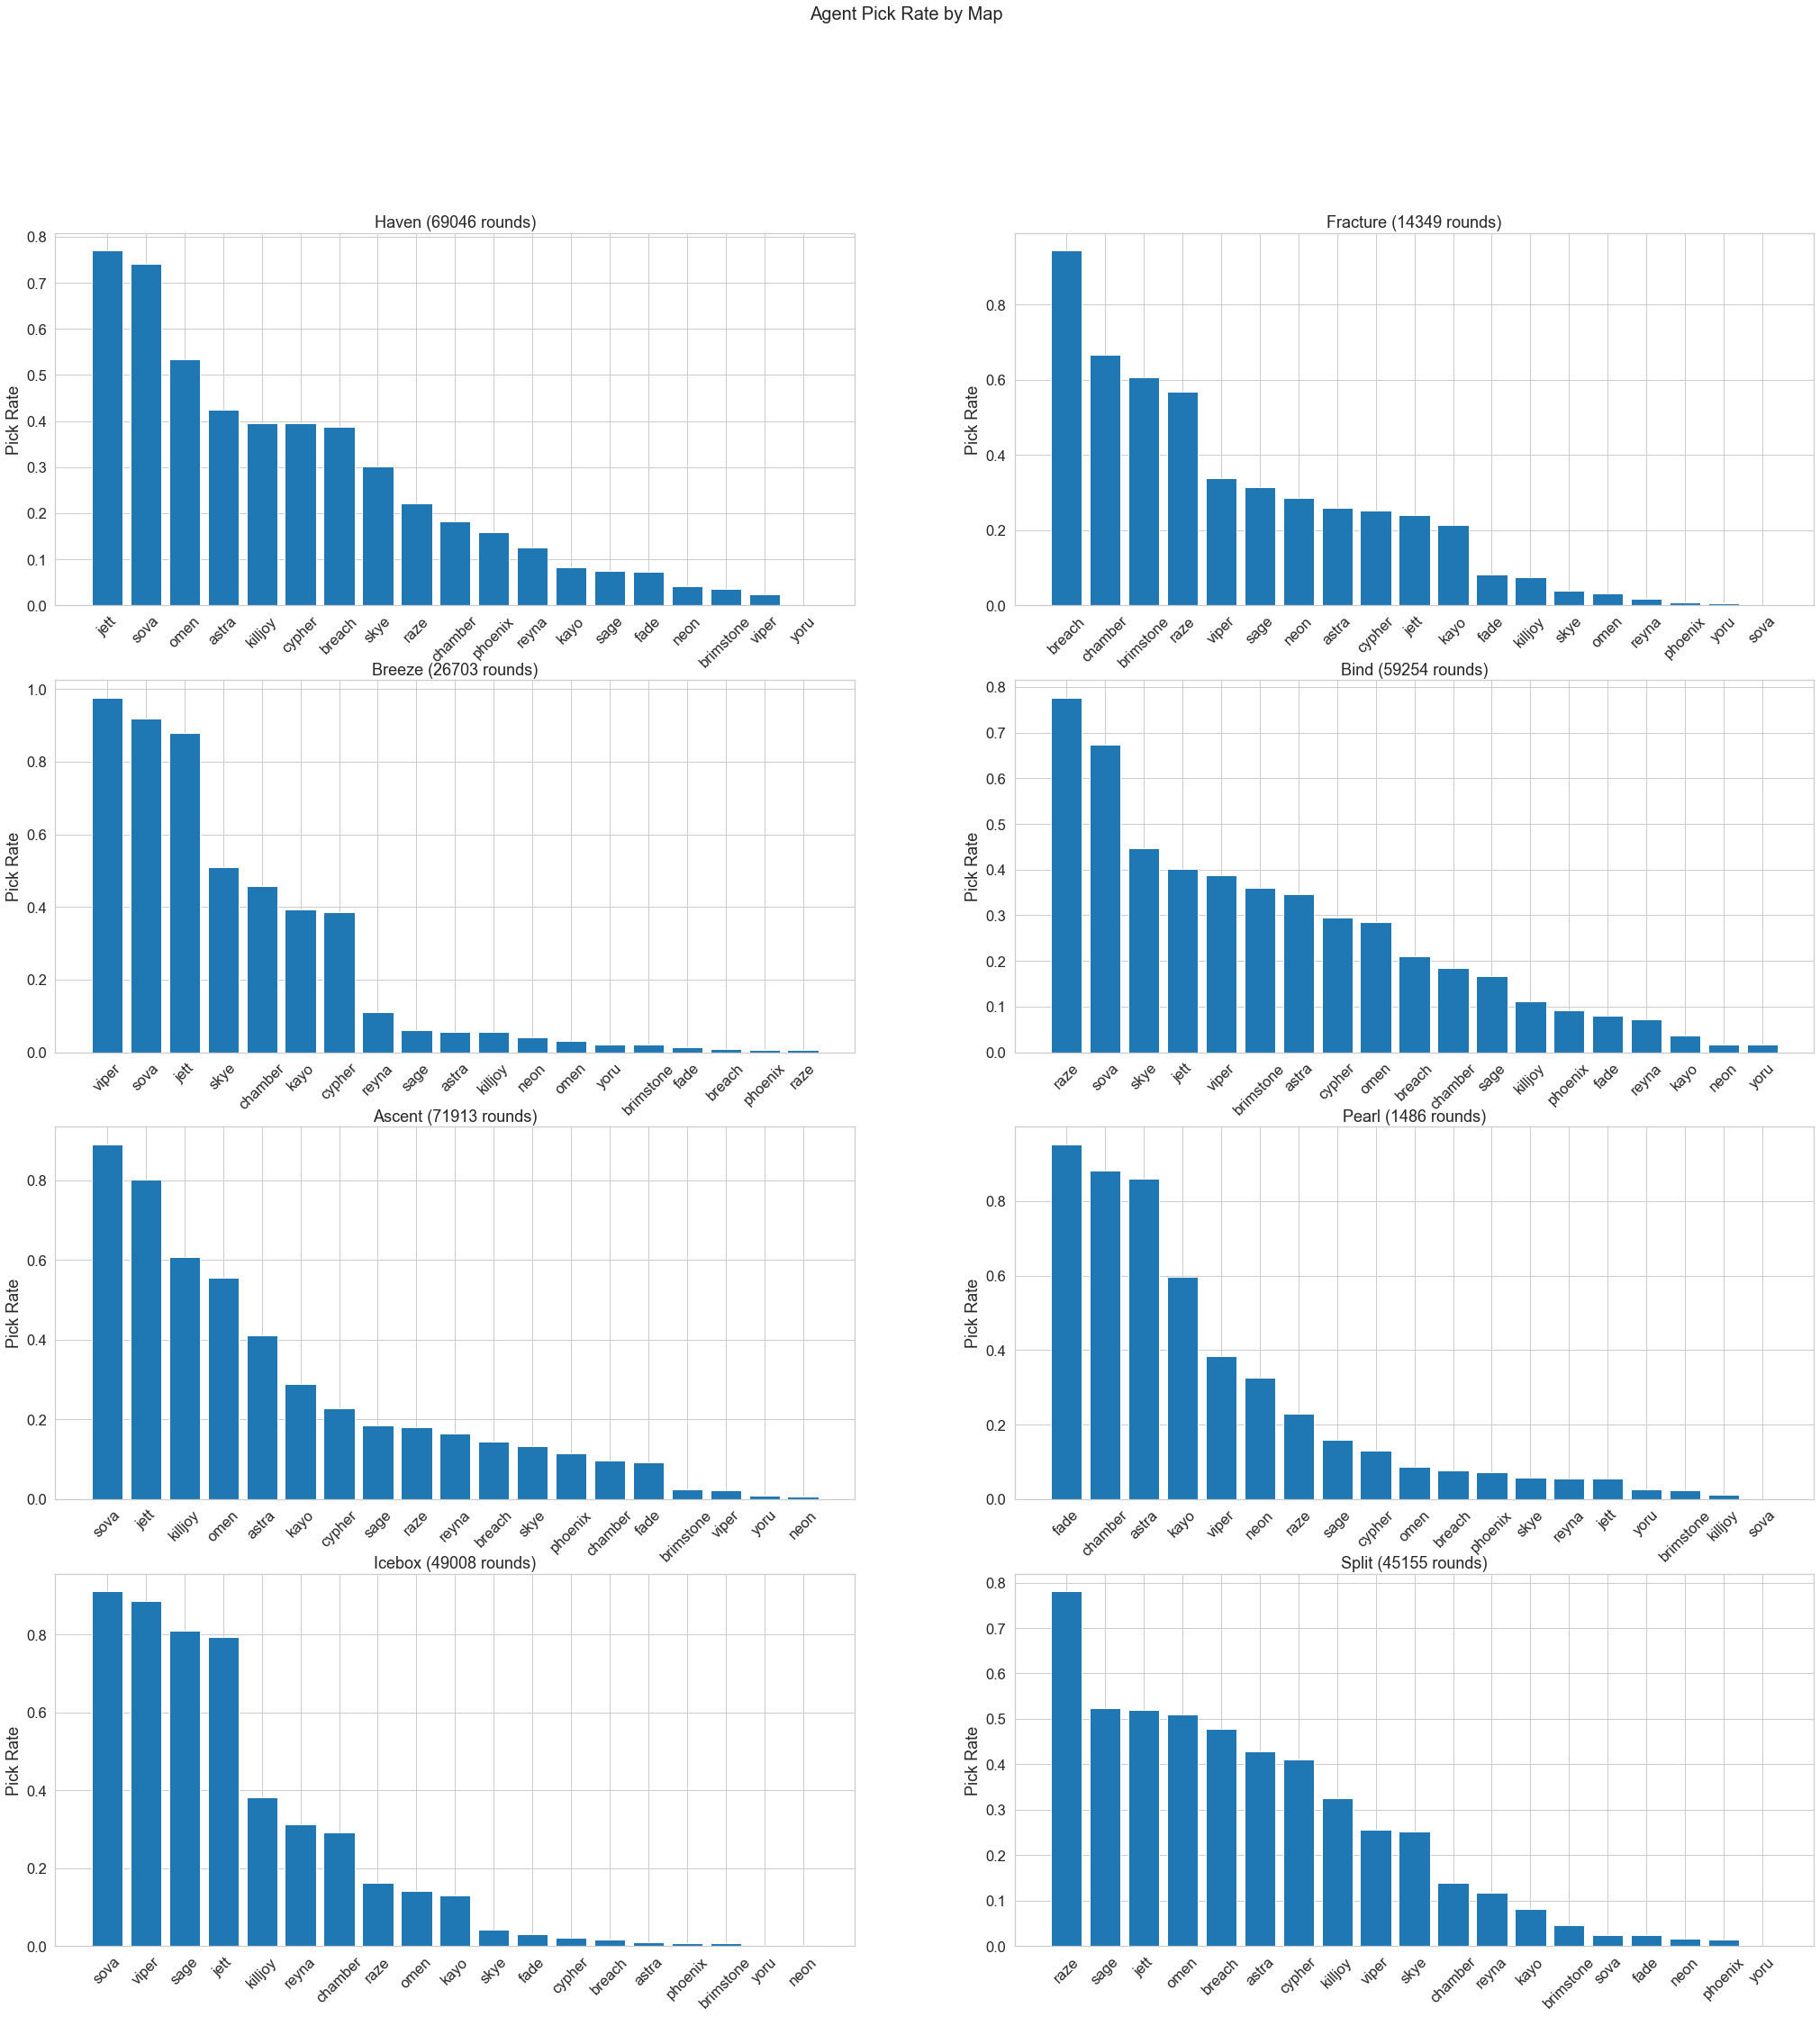

In [12]:
sns.set(font_scale=1.5,style='whitegrid')
maps = df['Map'].unique()
fig, ax = plt.subplots(4, 2, figsize=(35,35))
ax = ax.flatten()
fig.suptitle('Agent Pick Rate by Map', fontsize=20)
for i, map in enumerate(maps):
    team1_only_cols = [col for col in df.columns if col.startswith('team1_')]
    team1_only_pick_rates = [df.loc[df['Map'] == map][col].mean() for col in team1_only_cols]
    team1_only_pick_rates, team1_only_cols = zip(*sorted(zip(team1_only_pick_rates, team1_only_cols), reverse=True))
    team1_only_cols = [col.split('_')[-1] for col in team1_only_cols]

    ax[i].bar(team1_only_cols, team1_only_pick_rates, color='#1f77b4')
    ax[i].set_ylabel('Pick Rate')
    ax[i].set_xticklabels(team1_only_cols, rotation=45)
    ax[i].set_title(f'{map} ({len(df[df["Map"] == map])} rounds)')

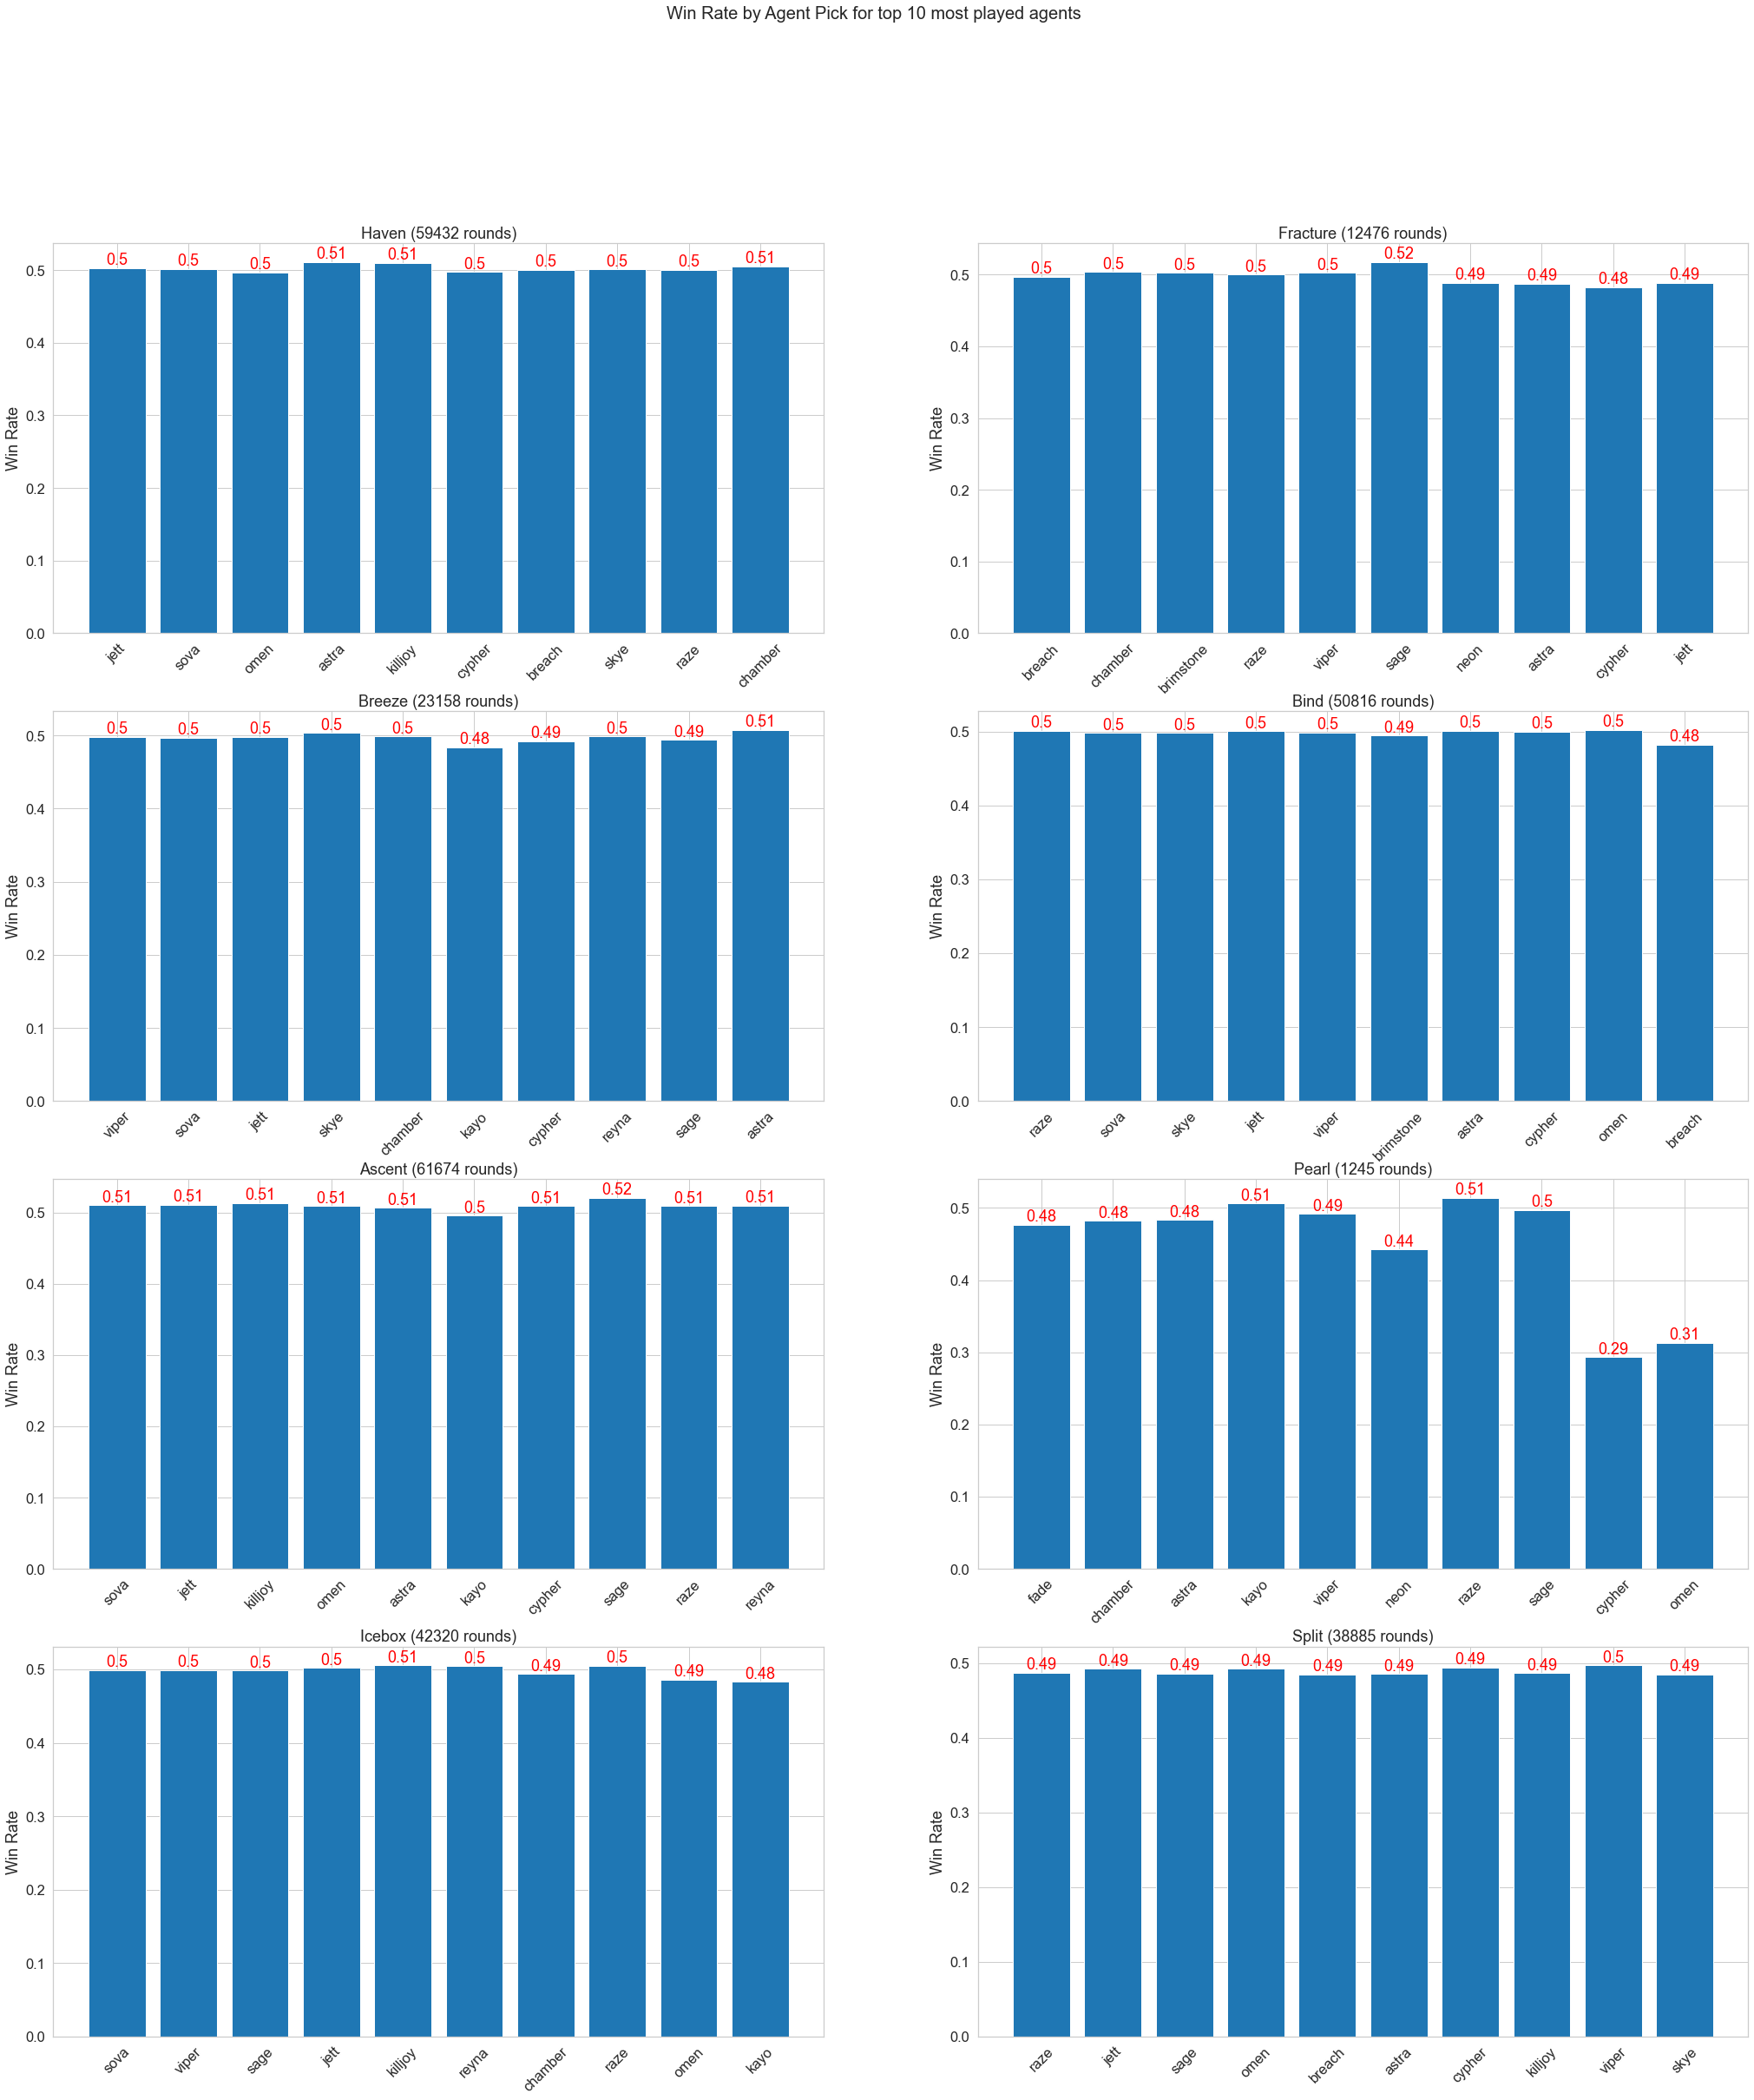

In [13]:
sns.set(font_scale=1.5,style='whitegrid')
maps = df_os['Map'].unique()
fig, ax = plt.subplots(4, 2, figsize=(35,38))
ax = ax.flatten()
fig.suptitle('Win Rate by Agent Pick for top 10 most played agents', fontsize=20)
for i, map in enumerate(maps):
    team1_only_cols = [col for col in df_os.columns if col.startswith('team1_')]
    team1_only_win_rates = [df_os.loc[(df_os[col] == 1) & (df_os['Map'] == map)]['Team1Win'].mean() for col in team1_only_cols]
    team1_only_cols_counts = [df_os.loc[(df_os[col] == 1) & (df_os['Map'] == map)]['Team1Win'].count() for col in team1_only_cols]
    team1_only_cols_counts_df = pd.DataFrame({'Agent': team1_only_cols, 'Count': team1_only_cols_counts})
    team1_only_cols_counts_df = team1_only_cols_counts_df.sort_values(by='Count', ascending=False)
    team1_only_cols=(team1_only_cols_counts_df.head(10)['Agent'].values)
    team1_only_win_rates = [df_os.loc[(df_os[col] == 1) & (df_os['Map'] == map)]['Team1Win'].mean() for col in team1_only_cols]
    team1_only_cols = [col.split('_')[-1] for col in team1_only_cols]
    ax[i].bar(team1_only_cols, team1_only_win_rates, color='#1f77b4')
    ax[i].set_ylabel('Win Rate')
    ax[i].set_xticklabels(team1_only_cols, rotation=45)
    ax[i].set_title(f'{map} ({len(df_os[df_os["Map"] == map])} rounds)')
    for j, v in enumerate(team1_only_win_rates):
        ax[i].text(j, v, str(round(v, 2)), color='red', ha='center', va='bottom')
    ax[i].set_xlabel('')

I chose to only feed into my model whether one team had an agent while the other team did not. In valorant when two teams have the same agents it is called a 'mirror match.'

Most Agents win rates appear to be near baseline. I then chose to look at non-mirror win rates for agents. Non-mirror is when only 1 team picks an agent

In [14]:
for agent in [col.split("_")[1] for col in[col for col in df.columns if col.startswith('team1_')]]:
    df['team1_only_' + agent] = np.where((df['team1_' + agent] == 1) & (df['team2_' + agent] == 0), 1, 0)
    df['team2_only_' + agent] = np.where((df['team1_' + agent] == 0) & (df['team2_' + agent] == 1), 1, 0)

In [15]:
for agent in [col.split("_")[1] for col in[col for col in df_os.columns if col.startswith('team1_')]]:
    df_os['team1_only_' + agent] = np.where((df_os['team1_' + agent] == 1) & (df_os['team2_' + agent] == 0), 1, 0)
    df_os['team2_only_' + agent] = np.where((df_os['team1_' + agent] == 0) & (df_os['team2_' + agent] == 1), 1, 0)

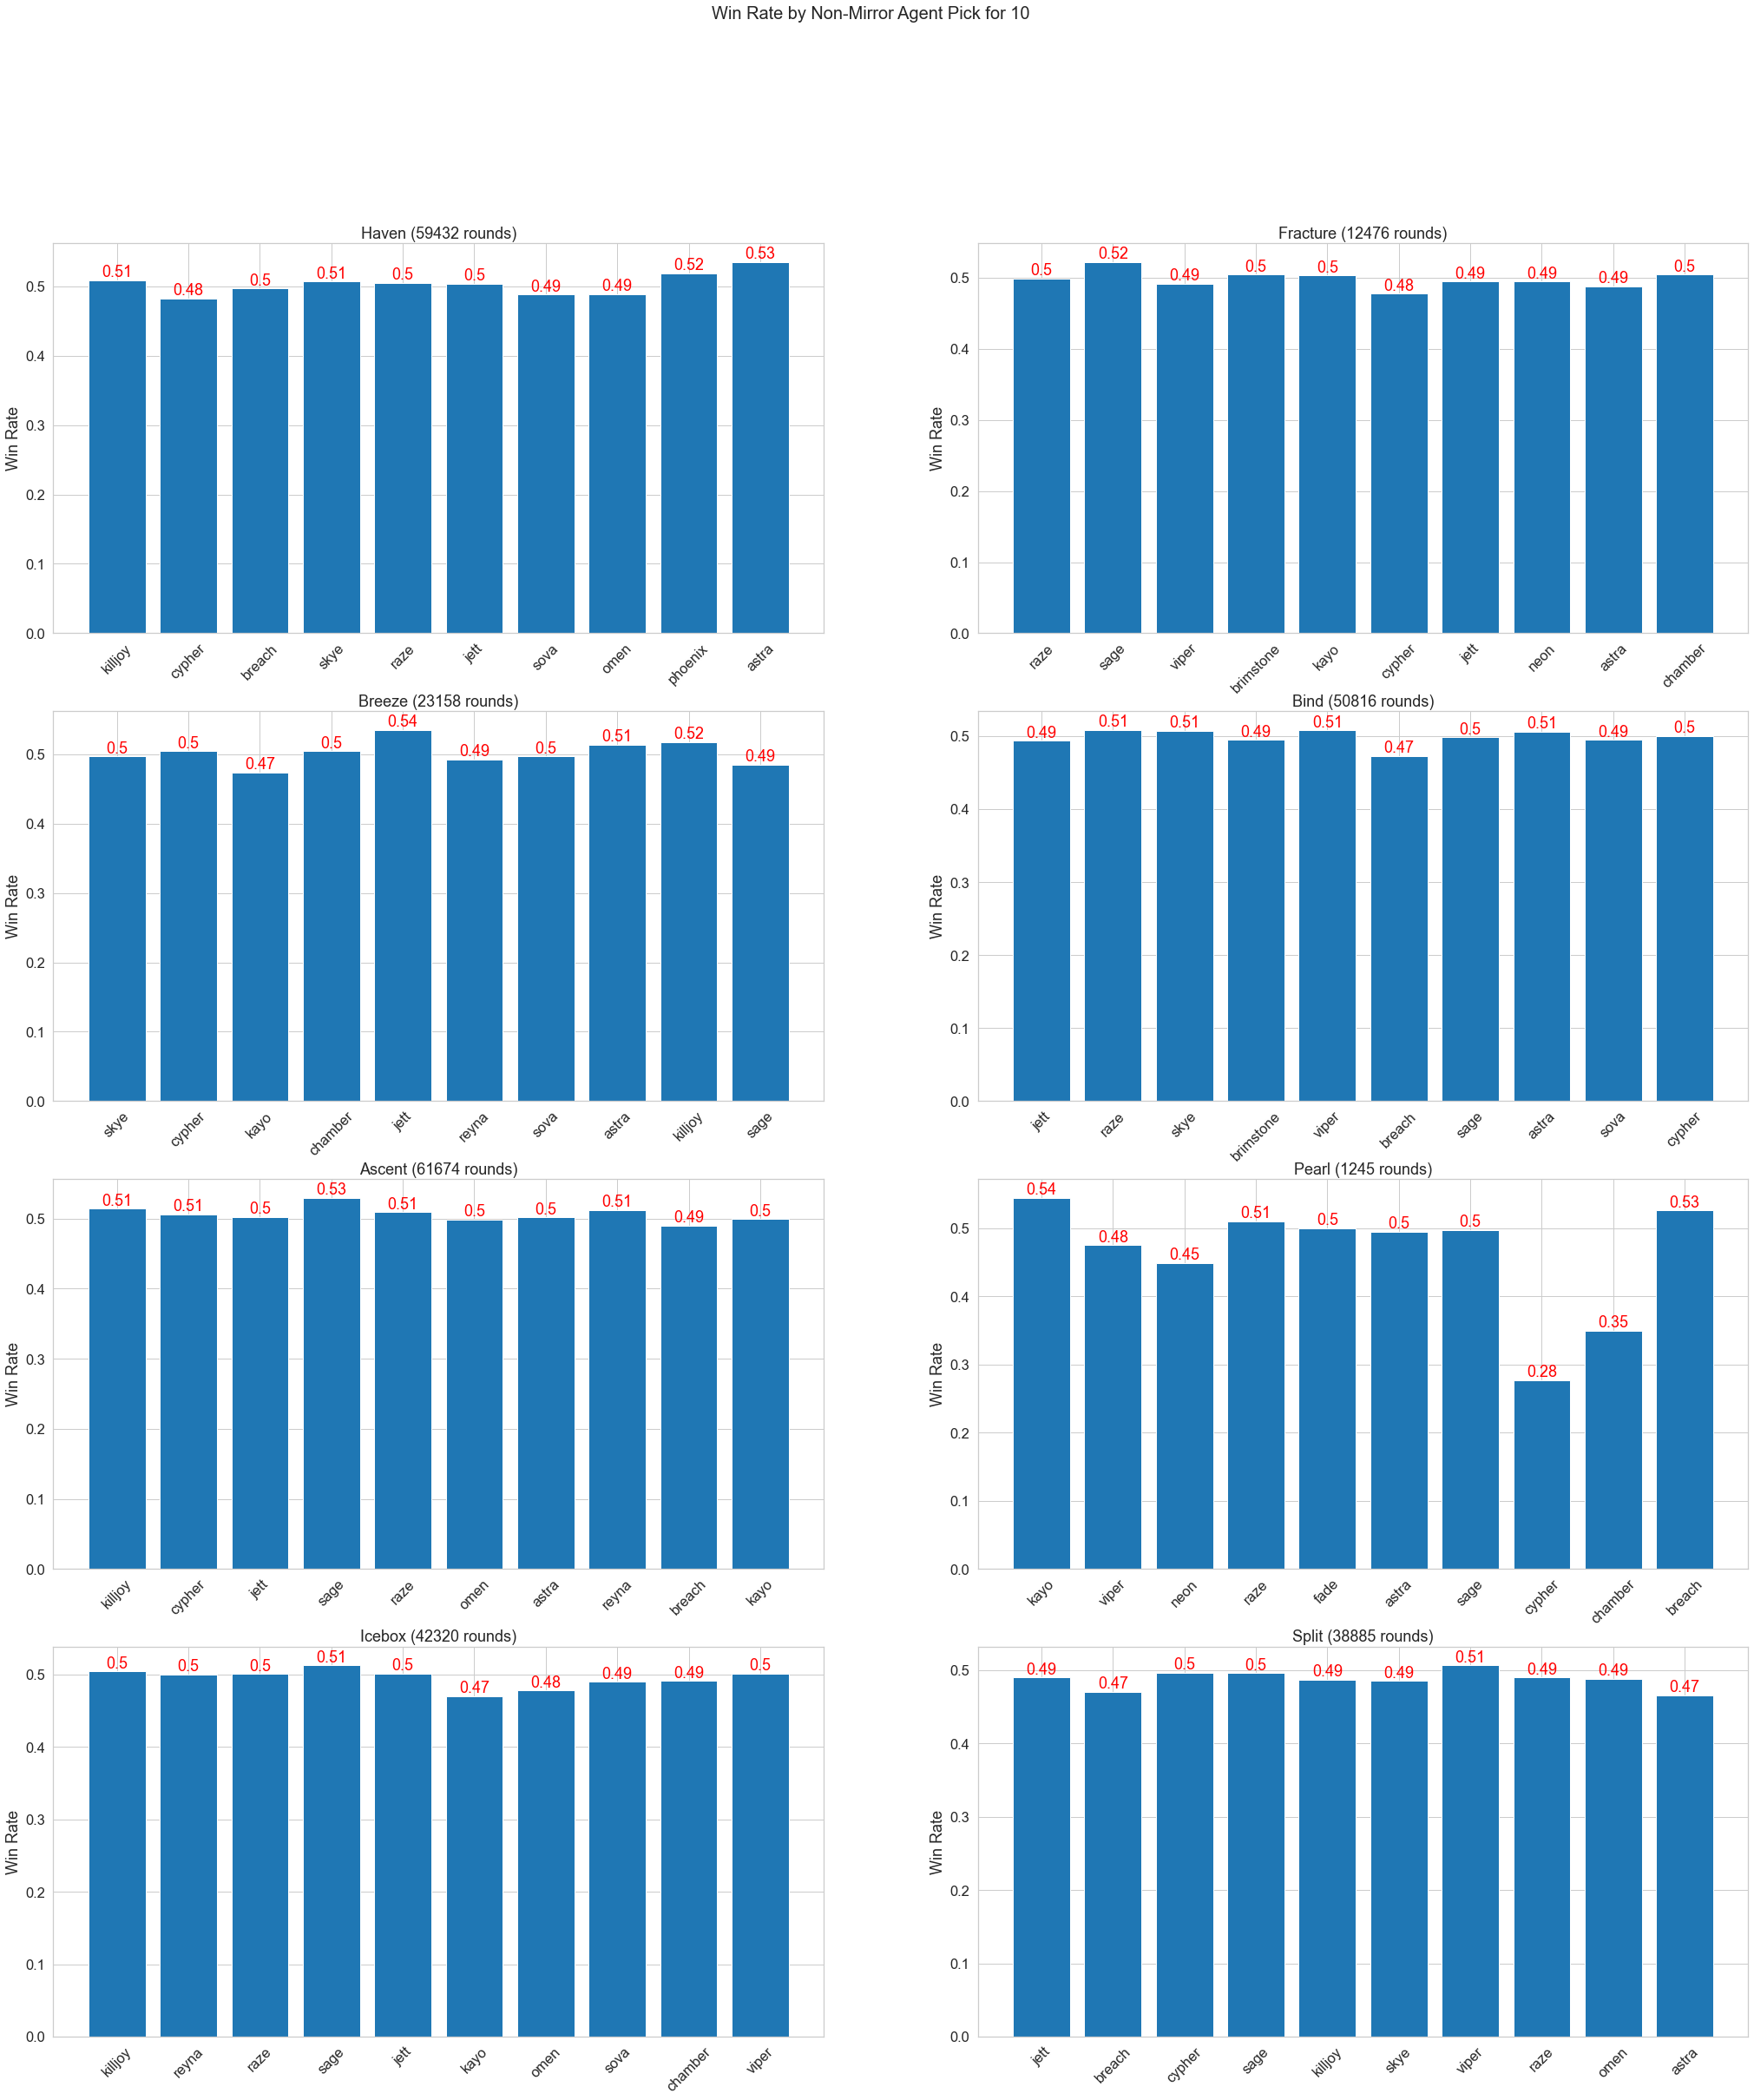

In [16]:
sns.set(font_scale=1.5,style='whitegrid')
maps = df_os['Map'].unique()
fig, ax = plt.subplots(4, 2, figsize=(35,38))
ax = ax.flatten()
fig.suptitle('Win Rate by Non-Mirror Agent Pick for 10 ', fontsize=20)
for i, map in enumerate(maps):
    team1_only_cols = [col for col in df_os.columns if col.startswith('team1_only_')]
    team1_only_win_rates = [df_os.loc[(df_os[col] == 1) & (df_os['Map'] == map)]['Team1Win'].mean() for col in team1_only_cols]
    team1_only_cols_counts = [df_os.loc[(df_os[col] == 1) & (df_os['Map'] == map)]['Team1Win'].count() for col in team1_only_cols]
    team1_only_cols_counts_df = pd.DataFrame({'Agent': team1_only_cols, 'Count': team1_only_cols_counts})
    team1_only_cols_counts_df = team1_only_cols_counts_df.sort_values(by='Count', ascending=False)
    team1_only_cols=(team1_only_cols_counts_df.head(10)['Agent'].values)
    team1_only_win_rates = [df_os.loc[(df_os[col] == 1) & (df_os['Map'] == map)]['Team1Win'].mean() for col in team1_only_cols]
    team1_only_cols = [col.split('_')[-1] for col in team1_only_cols]
    ax[i].bar(team1_only_cols, team1_only_win_rates, color='#1f77b4')
    ax[i].set_ylabel('Win Rate')
    ax[i].set_xticklabels(team1_only_cols, rotation=45)
    ax[i].set_title(f'{map} ({len(df_os[df_os["Map"] == map])} rounds)')
    for j, v in enumerate(team1_only_win_rates):
        ax[i].text(j, v, str(round(v, 2)), color='red', ha='center', va='bottom')
    ax[i].set_xlabel('')
fig.savefig('../images/win_rate_by_non_mirror_agent_pick_for_10.png')

**Haven:**
Astra, Pheonix, Killjoy and skye all have win rates above .5 for their non-mirror matchup. 

**Fracture:**
Sage is the only agent to have a win rate above .5 for their non-mirror matchup. 

**Breeze:**
Astra, Jett, and Killjoy all have win rates above .5 for their non-mirror matchup. 

**Bind:**
Raze, Skye, Viper and Astra all have win rates above .5 for their non-mirror matchup. 

**Ascent:**
Sage, Killjoy, Reyna and Cypher all have win rates above .5 for their non-mirror matchup. 

**Pearl:**
Not enough matches have been played on pearl to determine which agents to pick

**Icebox:**
Sage is the only agent to have a win rate above .5 for their non-mirror matchup. 

**Split:**
Viper is the only agent to have a win rate above .5 for their non-mirror matchup. 

**Note:** Any agent with a winrate .5 and above should be considered a viable pick on the map.

In [17]:
df.drop(['team2_astra',
       'team2_breach', 'team2_brimstone', 'team2_chamber', 'team2_cypher',
       'team2_fade', 'team2_jett', 'team2_kayo', 'team2_killjoy', 'team2_neon',
       'team2_omen', 'team2_phoenix', 'team2_raze', 'team2_reyna',
       'team2_sage', 'team2_skye', 'team2_sova', 'team2_viper', 'team2_yoru',
       'team1_astra', 'team1_breach', 'team1_brimstone', 'team1_chamber',
       'team1_cypher', 'team1_fade', 'team1_jett', 'team1_kayo',
       'team1_killjoy', 'team1_neon', 'team1_omen', 'team1_phoenix',
       'team1_raze', 'team1_reyna', 'team1_sage', 'team1_skye', 'team1_sova',
       'team1_viper', 'team1_yoru'], axis=1, inplace=True)

In [18]:
dummies = pd.get_dummies(df['Map'], prefix='map_')
df = pd.concat([df, dummies], axis=1)

### Buy Type
In Valorant guns and agent abilities are purchased at the begining of each round. Any surviving players from the round before get to keep their gun from the previous round. Abilities carry over from each round regardless of a player surviving or not. 

Eco: 0-5k, Semi-eco: 5-10k, Semi-buy: 10-20k, Full buy: 20k+ 

VLR.gg only provides these 4 labels rather than the loadout value

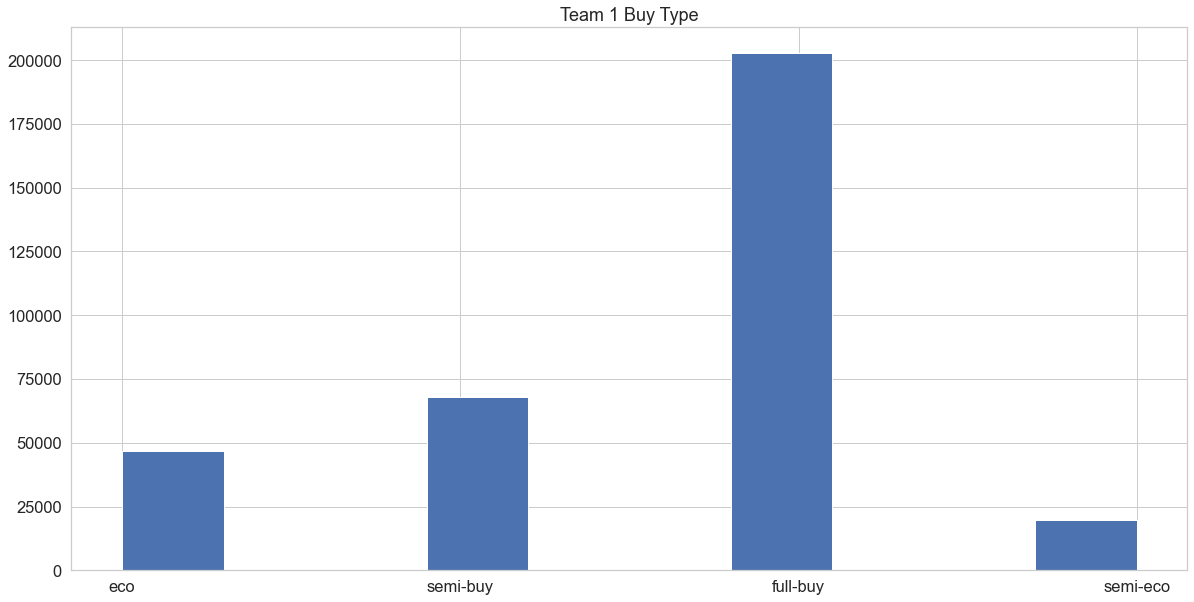

In [19]:
plt.figure(figsize=(20,10))
plt.hist(df['Team1BuyType'],  stacked=True, )
plt.title('Team 1 Buy Type');

Oversampling the minority class to balance the dataset before looking at Team 1 Win data.

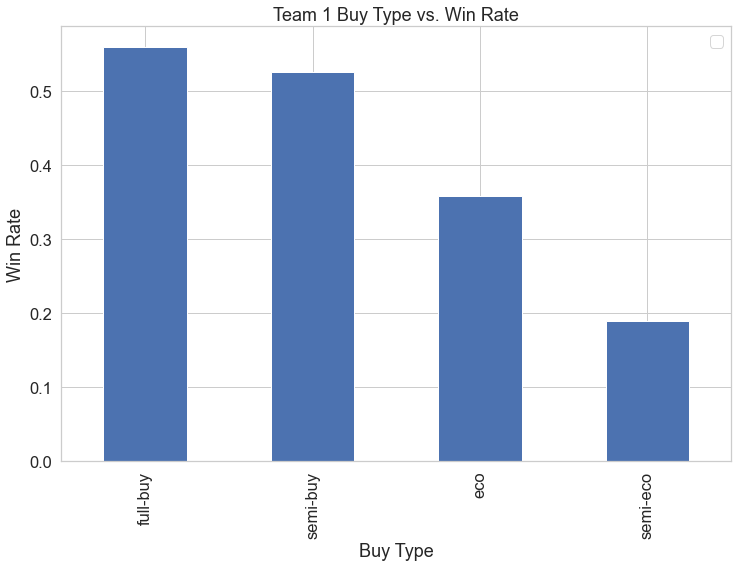

In [20]:
sns.set(font_scale=1.5,style='whitegrid')
win_rate = df_os.groupby('Team1BuyType').Team1Win.value_counts().unstack()
win_rate['win_rate'] = win_rate[1]/(win_rate[0]+win_rate[1])
win_rate.sort_values('win_rate',ascending=False,inplace=True)
win_rate.drop([0,1],axis=1,inplace=True)
win_rate.plot(kind='bar',figsize=(12,8))
plt.title('Team 1 Buy Type vs. Win Rate')
plt.xlabel('Buy Type')
plt.ylabel('Win Rate')
plt.legend('');
plt.savefig('../images/Team1BuyType_vs_WinRate.png')

The highest win rate per round is full-buy followed by semi-buy and then eco. The lowest win rate by buy type is for semi-eco. A team does not usually semi-eco unless they are going up against a full-buy or semi-buy. This is shown in more detail in the next graph.

### Win Rate by buy type matchup

In [21]:
# this shows the win rate of team1 given team1's buy type and team2's buy type.
# the yellow cells are the ones where the win rate is > 50% and < 100%
df_os.groupby(['Team1BuyType','Team2BuyType']).Team1Win.value_counts().unstack().apply(lambda x: x/x.sum(
), axis=1).assign(total=df_os.groupby(['Team1BuyType','Team2BuyType']).Team1Win.value_counts().unstack().sum(axis=1)
                 ).style.applymap(lambda x: 'background-color: yellow' if x > .51 and x < 1 else '')

##### **Buy Type Impact**

The table above shows the win rates for each team's buy type. The first column is the team's buy type, the second column is the opposing team's buy type, the third and fourth columns are the win rates for each team, and the last column is the total number of rounds played.

The table also confirms the hypothesis that semi-ecos only ever happen against full-buys and semi-buys.

From the table, we can see that when both teams are ecoing, the win rate is roughly even at 50%. However, when one team is ecoing and the other team is full-buying, the full-buying team has a much higher win rate of 89.9%. This is likely because the full-buying team has more powerful weapons and armor, which gives them a significant advantage over the ecoing team.

When both teams are full-buying, the win rate is lower at 50.7%. This is likely because both teams have access to the same powerful weapons and armor, so the match is more evenly matched.

Finally, when one team is semi-eco and the other team is full-buying, the win rate is lower at 63.0%. This is likely because the full-buying team has a significant advantage in weapons and armor over the semi-eco team.

##### **Results**

Overall, we can see that buy type has a significant impact on win rate. The full-buying team has the highest win rate, followed by the semi-buying team. The ecoing team has the lowest win rate.


### Bank

The bank metric consists of a teams total currency when the round starts.

In [22]:
np.max(df['Team1Bank'])

500000.0

The max bank a team can have is 60,000 so any rounds with a number above this are removed

In [23]:
df = df[df['Team1Bank']<=60_000]

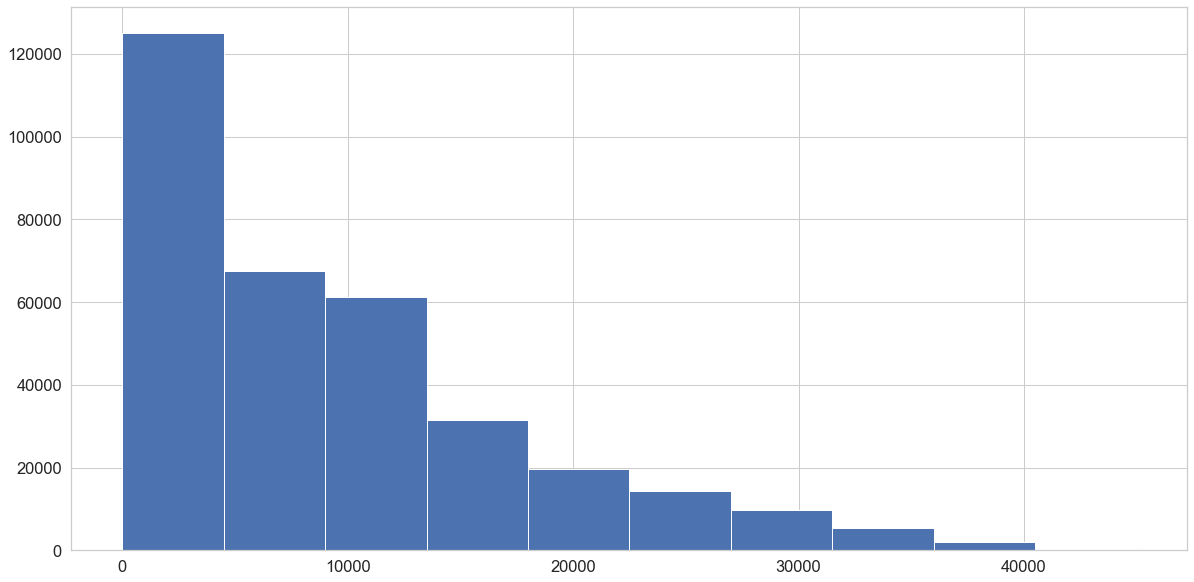

In [24]:
plt.figure(figsize=(20,10))
plt.hist(df['Team1Bank']);

Bank is skewed right so this may become an issue down the line that has to be dealt with

In [25]:
df_dif = pd.DataFrame({'bankDiff': df_os['Team1Bank'] - df_os['Team2Bank'], 'Team1Win': df_os['Team1Win'], 'RoundNo':df_os["RoundNo"]})

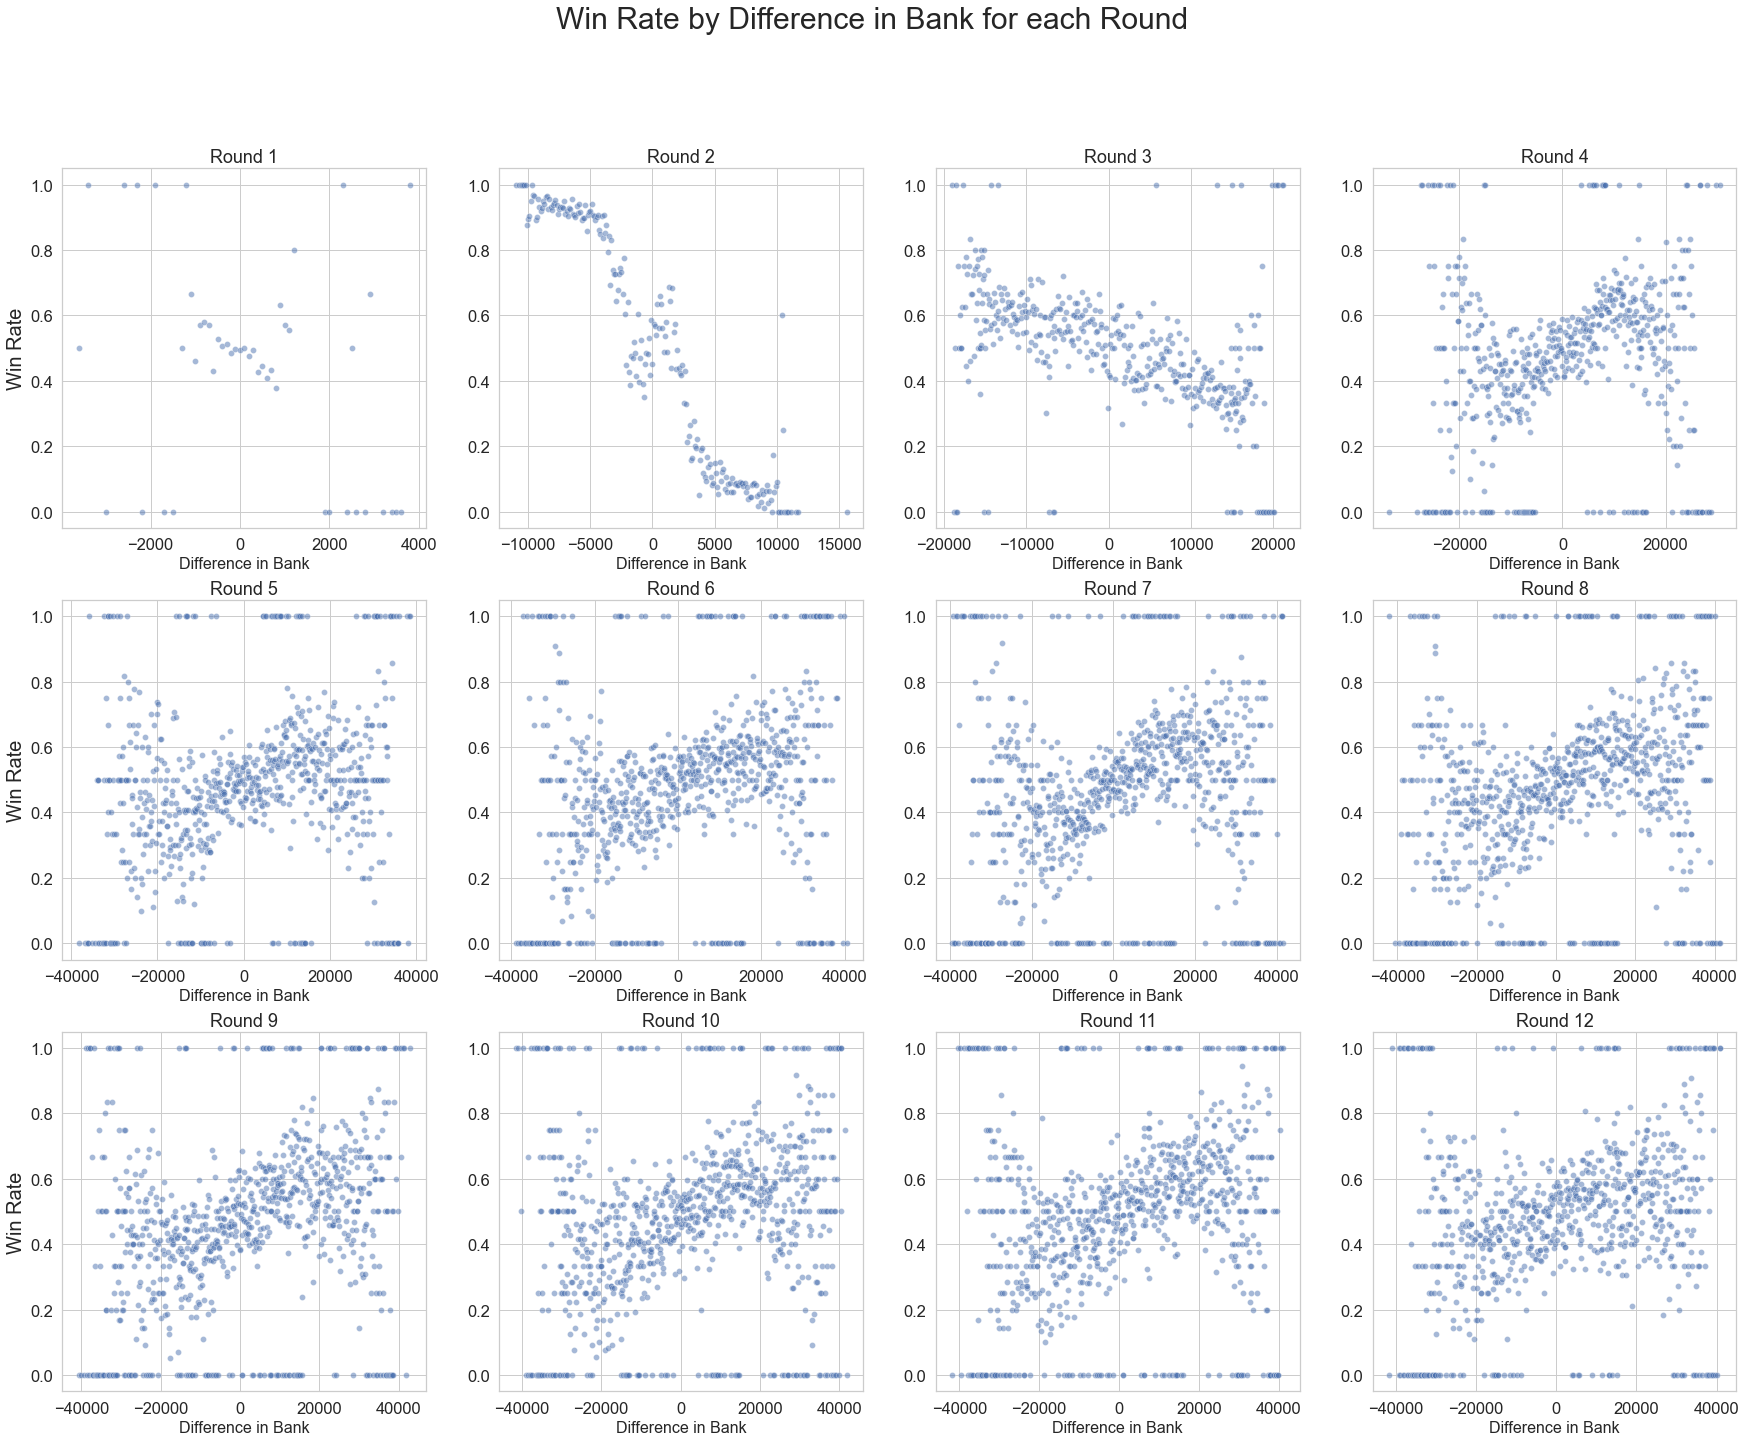

In [26]:
#plot win rates for each round as a function of bank difference
fig, axs = plt.subplots(3, 4, figsize=(30,22.5))
for i in range(0,12):    
    bankDiff_group = df_dif[(df_dif['RoundNo']==1+i)|(df_dif['RoundNo']==13+i)].groupby('bankDiff').mean()
    sns.scatterplot(x=bankDiff_group.index, y=bankDiff_group['Team1Win'], ax=axs[i//4, i%4], alpha=.5)
    axs[i//4, i%4].set_xlabel('Difference in Bank', fontsize=16)
    if i%4 == 0:
        axs[i//4, i%4].set_ylabel('Win Rate', fontsize=20)
    else:
        axs[i//4, i%4].set_ylabel('')
    axs[i//4, i%4].set_title(f'Round {i+1}')
    
fig.suptitle('Win Rate by Difference in Bank for each Round', fontsize=30)
plt.show()
fig.savefig('../images/winRate_bankDiff_round.png')

**There does appear to be a correlation between bank difference and win rate. It changes per round. Rounds 4-12 appear to have the same relationship. As a result I am going to create seperate models for rounds 1, 2, and 3. The other rounds can all be grouped into the same model.**

**Round 2** appears to have a strong negative correlation between difference in bank and and win rate. The change in relationship can be explained by how the economy in the game functions. In round 2, the team that lost round 1 generally does not buy and therefore has a larger bank. This team almost always loses round 2.

**Round 3** appears to have a negative correlation between difference in bank and and win rate. Round 3 is the 'bonus' round for the team that won rounds 1 and 2 and as a result they are usually going up against a full buy. They usually lose to the full buy but have a larger bank.

**Rounds above 3** appear to have a positive correlation between difference in bank and win rate. Rounds 4-12 appear to have the same relationship. As a result I am going to create seperate models for rounds 1, 2, and 3. 

I am adding lags for bank difference up to Lag 3.

In [27]:
df['bankDiff'] = df['Team1Bank']-df['Team2Bank']

In [28]:
for i in range(1,4):
    df['bankDiffLag'+str(i)] = df['Team1BankLag'+str(i)]-df['Team2BankLag'+str(i)]

In [29]:
df.drop(['RoundWinner','ScoreAfterRound', 'WinType', 'Team1Bank', 'Team2Bank',#'Team1WinLag4',
         'Team1WinLag5', 'Team1WinLag6',
       'Team1WinLag7', 'Team1WinLag8', 'Team1WinLag9', 'Team1WinLag10',
       'Team1WinLag11', 'Team1WinLag12', 'Team2WinLag9',  'map__Ascent', 'map__Bind', 'map__Breeze',
       'map__Fracture', 'map__Haven', 'map__Icebox', 'map__Pearl',
       'map__Split', 'GameID', 'Team1ID', 'Team2ID', 'Team1Abbr', 'Team2Abbr',], axis=1, inplace=True)

Dropping old columns. For my modeling I am going to use only up to 3 lags so I can create only 3 or 4 models (depending on overtime).

In [30]:
df= df.drop(df.filter(regex='Team1BankLag').columns, axis=1)
df= df.drop(df.filter(regex='Team2BankLag').columns, axis=1)

In [31]:
# one hot encoding for Team1BuyType
onehotencoding = pd.get_dummies(df['Team1BuyType'], prefix='Team1')
df = df.drop('Team1BuyType',axis = 1)
df = df.join(onehotencoding)

# one hot encoding for Team2BuyType
onehotencoding = pd.get_dummies(df['Team2BuyType'], prefix='Team2')
df = df.drop('Team2BuyType',axis = 1)
df = df.join(onehotencoding)

### Rounds

Win Rate by Rounds

In [32]:
df.groupby('RoundNo')['Team1Win'].mean()

RoundNo
1     0.559198
2     0.570099
3     0.549284
4     0.588462
5     0.572847
6     0.577575
7     0.581084
8     0.572856
9     0.568850
10    0.579725
11    0.579516
12    0.572359
13    0.570329
14    0.572333
15    0.552061
16    0.565742
17    0.558025
18    0.563048
19    0.559482
20    0.558080
21    0.563151
22    0.566854
23    0.574995
24    0.605061
25    0.582020
26    0.582649
27    0.582307
28    0.584270
29    0.597849
30    0.587097
31    0.570175
32    0.590308
33    0.547170
34    0.579439
35    0.607843
36    0.640000
37    0.500000
38    0.666667
39    0.571429
40    0.714286
41    0.666667
42    0.666667
Name: Team1Win, dtype: float64

There is an imbalance in 'Team1Win.' This will be dealt with by oversampling when creating the models. The reason the already established oversampled dataset is not used its that different models are being created for certain rounds dataset will be balanced independently.

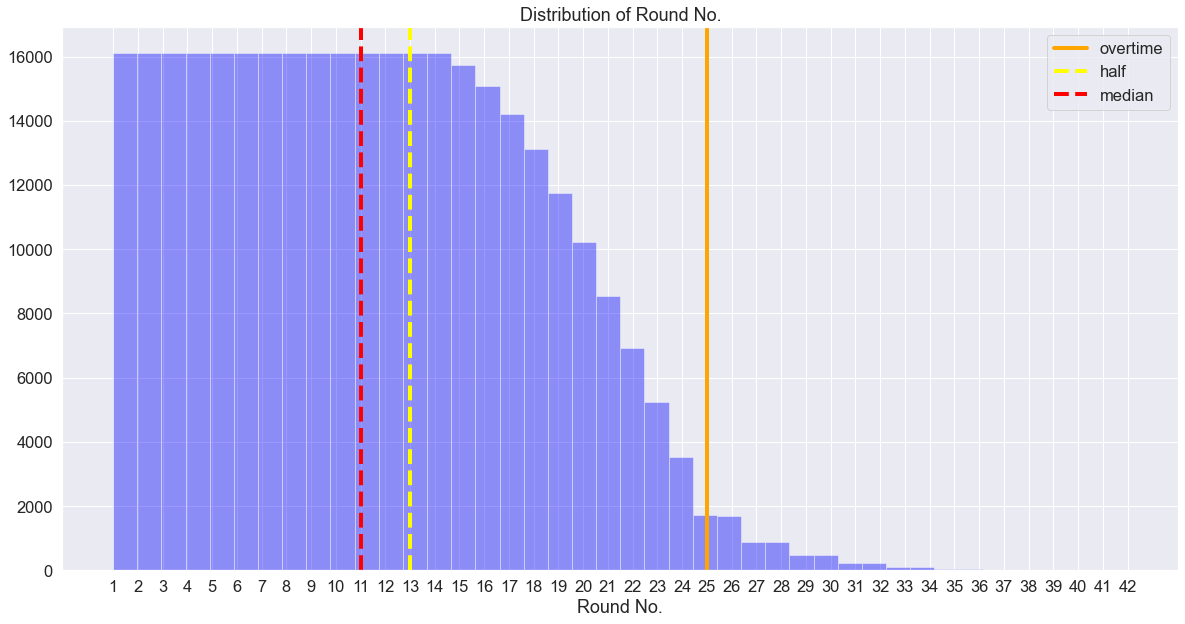

In [33]:
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(20, 10))
ax = sns.distplot(df['RoundNo'], bins=42, color='blue', kde=False)
ax.axvline(25, color='orange', linewidth=4, label='overtime')
ax.axvline(13, color='yellow', linewidth=4, linestyle='dashed', label='half')
ax.axvline(df['RoundNo'].median(), color='red', linewidth=4, linestyle='dashed', label='median')
ax.set_xticks(range(1, 43))
ax.set_xlabel('Round No.')
ax.set_title('Distribution of Round No.')
ax.legend()

Every match has at least 13 rounds. Since I removed all games that were 13-0, every match in this dataset has 14 rounds. The median Round number is round 11. 

#### Correlation

In [34]:
%%capture cap --no-stderr
print (show_top5_correlated(df.drop('Map',axis=1)))

In [35]:
with open('../correlation/output.txt', 'w') as f:
    f.write(cap.stdout)

The output of my correlation function is large due to the large amount of columns. I wrote the output to a txt file. 

There does appear to be collinearity in my dataframe. I will first attempt to make a model based on my current dataframe to find feature importance before applying PCA to create an uncorrelated dataframe in the modeling notebook.

### Baseline : .57

In [36]:
df['Team1Win'].mean()

0.569612926779317

Check What percentage of rounds are won after a win.

### Baseline for Time Series Models: .66

In [37]:
df[['Team1Win','Team1WinLag1']].dropna().groupby(by=df['Team1WinLag1']).mean()['Team1Win'][1]

0.6607656512033407

This is one possible measure for our baseline

In [38]:
df.columns =  [col.lower().replace('-','_') for col in df.columns]

In [39]:
df.isna().sum()

team1win                    0
team1winlag1            16107
team1winlag2            32220
team1winlag3            48341
team1winlag4            64461
roundno                     0
rounddiff                   0
map                         0
team1_only_astra            0
team2_only_astra            0
team1_only_breach           0
team2_only_breach           0
team1_only_brimstone        0
team2_only_brimstone        0
team1_only_chamber          0
team2_only_chamber          0
team1_only_cypher           0
team2_only_cypher           0
team1_only_fade             0
team2_only_fade             0
team1_only_jett             0
team2_only_jett             0
team1_only_kayo             0
team2_only_kayo             0
team1_only_killjoy          0
team2_only_killjoy          0
team1_only_neon             0
team2_only_neon             0
team1_only_omen             0
team2_only_omen             0
team1_only_phoenix          0
team2_only_phoenix          0
team1_only_raze             0
team2_only

In [40]:
df.shape

(336913, 58)

In [41]:
df.to_csv('../data/modeling1.csv')